In [32]:
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time


plt.rcParams["font.family"] = "Times New Roman"

df = pd.read_csv('../data/metabric_example.tab', sep='\t')

# Calculate the median of the FLT3 column
median_flt3 = df['FLT3'].median()

# Create two groups: below and above median
flt3_low = df['FLT3'] <= median_flt3
flt3_high = df['FLT3'] > median_flt3


/var/folders/rv/jt6y7k_x4gs3_r7tcpxzmp9m0000gn/T/ipykernel_57373/717735845.py:95: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[0, 0])
/var/folders/rv/jt6y7k_x4gs3_r7tcpxzmp9m0000gn/T/ipykernel_57373/717735845.py:105: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[0, 1])


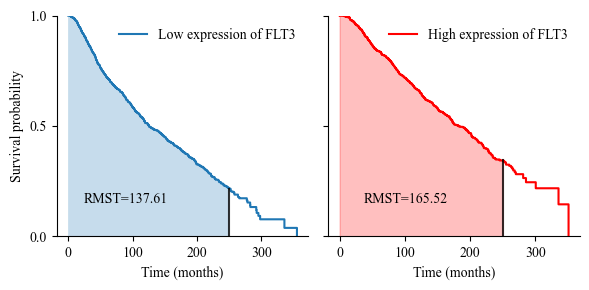

In [36]:
def rmst_plot(model, model2=None, t=np.inf, ax=None, text_position=None, **plot_kwargs):
    """this part of the code is taken from lifelines.plotting and adopted for the needs of our figure"""

    from lifelines.utils import restricted_mean_survival_time
    from matplotlib import pyplot as plt


    if ax is None:
        ax = plt.gca()

    rmst = restricted_mean_survival_time(model, t=t)
    c = plot_kwargs.pop("c", None)
    model.plot_survival_function(ax=ax, color=c, ci_show=False, **plot_kwargs)

    if text_position is None:
        text_position = (np.percentile(model.timeline, 10), 0.15)

    if model2 is not None:
        # c2 = ax._get_lines.get_next_color()
        c = 'red'
        rmst2 = restricted_mean_survival_time(model2, t=t)
        model2.plot_survival_function(ax=ax, color=c, ci_show=False, **plot_kwargs)
        timeline = np.unique(model.timeline.tolist() + model2.timeline.tolist() + [t])
        predict1 = model.predict(timeline).loc[:t]
        predict2 = model2.predict(timeline).loc[:t]

        ax.fill_between(
            timeline[timeline <= t],
            predict1,
            predict2,
            where=predict1 > predict2,
            step="post",
            color="grey", alpha=0.25,
            edgecolor="grey",
        )

        ax.fill_between(
            timeline[timeline <= t],
            predict1,
            predict2,
            where=predict1 < predict2,
            step="post",
            color="grey", alpha=0.25,
            edgecolor="grey",
        )

        y_val = model.predict(t)
        y_val2 = model2.predict(t)
        ax.axvline(t, y_val2, y_val, ls="-", color="k", alpha=0.8)
    else:
        rmst = restricted_mean_survival_time(model, t=t)
        sf_exp_at_limit = model.predict(np.append(model.timeline, t)).sort_index().loc[:t]
        ax.fill_between(sf_exp_at_limit.index, sf_exp_at_limit.values, step="post", color=c, alpha=0.25)
        ax.text(text_position[0], text_position[1], "RMST=%.2f" % rmst)  # dynamically pick this.

        y_val = model.predict(t)
        ax.axvline(t, 0, y_val, ls="-", color="k", alpha=0.8)

    ax.set_ylim(0, 1)
    return ax


time = 250

kmf = KaplanMeierFitter()
kmf_low = kmf.fit(df['time'][flt3_low], df['event'][flt3_low], label='Low expression of FLT3')
rmst_low = restricted_mean_survival_time(kmf_low, t=time)

kmf = KaplanMeierFitter()
kmf_high = kmf.fit(df['time'][flt3_high], df['event'][flt3_high], label='High expression of FLT3')
rmst_high = restricted_mean_survival_time(kmf_high, t=time)



fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(6, 3))

gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
rmst_plot(kmf_low, t=time, ax=ax)
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0, 100, 200, 300])
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Time (months)")

ax = plt.subplot(gs[0, 1])
r = rmst_plot(kmf_high, t=time, ax=ax, c='red')
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([])
ax.set_xticks([0, 100, 200, 300])
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.legend(loc='upper right', frameon=False)
ax.set_xlabel("Time (months)")


fig.tight_layout()
plt.savefig('../figures/figure2_rmst.pdf', dpi=300)


/var/folders/rv/jt6y7k_x4gs3_r7tcpxzmp9m0000gn/T/ipykernel_57373/2800449122.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[0, :])


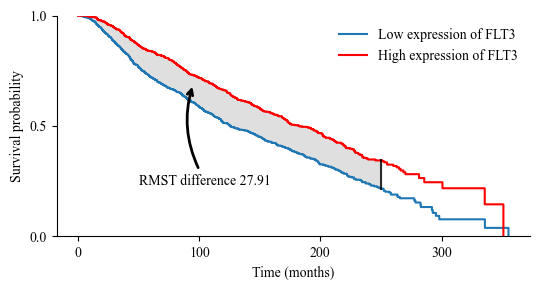

In [37]:
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(5.5, 3)) # figsize=(5, 3.2)

gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, :])
rmst_plot(kmf_low, model2=kmf_high, t=time, ax=ax)

arrow = FancyArrowPatch((100, 0.3), (95, 0.69), connectionstyle="arc3,rad=-.2", mutation_scale = 10, arrowstyle='->', lw=2, zorder=10)
ax.add_patch(arrow)
ax.text( 50, 0.25, f"RMST difference {abs(round(rmst_high - rmst_low, 2))}", fontsize=10, ha='left', va='center', zorder=10)
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0, 100, 200, 300])
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Time (months)")

fig.tight_layout()

plt.savefig('../figures/figure3_rmst_diff_small.pdf', dpi=300)